## Description

This file will contain the preprocessing of brain recordings comparing resting state behavior with tapping activity. 
It will take the following steps:

1. Prepare environment
2. Import data (1 participant at a time)
3. Clean data:
    1. Apply filtering (0.5 - 50Hz)
    2. Apply Notch
    3. Remove flatlined channels
    4. Mark noisy channels
    5. Perform ICA
    6. Remove components that correlated with EOG and ECG
    7. Remove muscle components (spiky activity in 20-50Hz frequency range)
    8. Interpolate noisy channels
4. Re-reference data
5. Store cleaned data for analysis

In [1]:
# Perform required imports
import os
import PyQt5
import mne
import matplotlib.pyplot as plt
import numpy as np
from mne.preprocessing import ICA
import sklearn
from mne.time_frequency import psd_array_welch
%matplotlib qt


In [2]:
# Set the participant ID
participant_id = "P03"

# Construct the folder path
folder_path = f'../Data/Pilot/{participant_id}/'

# Find the first .vhdr file in the folder
vhdr_files = [f for f in os.listdir(folder_path) if f.endswith('.vhdr')]
if not vhdr_files:
    raise FileNotFoundError(f"No .vhdr file found in {folder_path}")
eeg_file = os.path.join(folder_path, vhdr_files[0])

# Load the EEG data
raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Extracting parameters from ../Data/Pilot/P03/Apathy_Agency_2025-02-12_14-49-52.vhdr...
Setting channel info structure...
Reading 0 ... 8430311  =      0.000 ...  8430.311 secs...


C:\Users\ymijs\AppData\Local\Temp\ipykernel_10996\3010530786.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


In [3]:
# Filter data to be within the 0.5 and 40 Hz frequency bands, outside is likely noise
raw.filter(l_freq=0.1, h_freq=40.0)  


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.3s


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 68 x 8430312 (8430.3 s), ~4.27 GB, data loaded>

In [4]:
# Set ECG, EOG and Photodiode channels
raw.set_channel_types({
    'BIP3': 'dipole',  # Replace 'ECG' with the actual name of your ECG channel
    'BIP7': 'ecg',  # Replace 'EOG1' with the actual name of your EOG channel
    'BIP8': 'eog',    # Replace 'EMG' with the actual name of your EMG channel
    'BIP9': 'eog'    # Replace 'EMG' with the actual name of your EMG channel
})


C:\Users\ymijs\AppData\Local\Temp\ipykernel_10996\2067019438.py:2: RuntimeWarning: The unit for channel(s) BIP3 has changed from V to NA.
  raw.set_channel_types({


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 68 x 8430312 (8430.3 s), ~4.27 GB, data loaded>

In [5]:
# Remove EOG channel, which was connected to cap, but was not used, same for M1 and M2
unused_channels = ['M1', 'M2'] # Build-in EOG channel in cap was not used
raw.drop_channels(unused_channels)


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 66 x 8430312 (8430.3 s), ~4.15 GB, data loaded>

In [ ]:
# Completely remove flatlined channels, before ICA 
raw.info['bads'] = []
non_eeg_channels = ['BIP3', 'BIP7', 'BIP8', 'BIP9']

# Identify flat-lined channels and mark them as bad
channel_std = np.std(raw.get_data(), axis=1)
flatlined_channels = [ch_name for ch_name, std in zip(raw.ch_names, channel_std) if std < 1e-6]
print(f"Flatlined channels: {flatlined_channels}")
raw.drop_channels(flatlined_channels)


In [13]:

# Identify noisy channels, mark them as bad, but don't drop them just yet
# Calculate peak-to-peak amplitude for each channel
channel_ranges = np.ptp(raw.get_data(), axis=1)
raw.info['bads'] = []
# Define a threshold for noisy channels (e.g., > 150 μV) ADJUST BASED ON # OF BADS
noisy_channels = [ch_name for ch_name, rng in zip(raw.ch_names, channel_ranges) if rng > 550e-6]
print(f"Noisy channels: {noisy_channels}")
raw.info['bads'].extend(noisy_channels)
raw.info['bads'] = [
    ch_name for ch_name in raw.info['bads']
    if ch_name not in non_eeg_channels
]# Mark them as bad
print(len(raw.info['bads']))
print(raw.info['bads'])

raw.save(f'{participant_id}_raw_EEG_filtered_and_marked.fif', overwrite=True)


Noisy channels: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'C4', 'T8', 'CP6', 'P7', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F6', 'FC4', 'C5', 'C1', 'C6', 'CP3', 'CP4', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'Oz_1', 'BIP3', 'BIP7', 'BIP8', 'BIP9']
36
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'C4', 'T8', 'CP6', 'P7', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F6', 'FC4', 'C5', 'C1', 'C6', 'CP3', 'CP4', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'Oz_1']
Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_raw_EEG_filtered_and_marked.fif


C:\Users\ymijs\AppData\Local\Temp\ipykernel_10996\672103901.py:16: RuntimeWarning: This filename (c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_raw_EEG_filtered_and_marked.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(f'{participant_id}_raw_EEG_filtered_and_marked.fif', overwrite=True)


Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_raw_EEG_filtered_and_marked.fif
Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_raw_EEG_filtered_and_marked-1.fif
Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_raw_EEG_filtered_and_marked-1.fif
[done]


In [14]:
# Apply ICA, with flatlined channels dropped (not interpolated) and with noisy channels just marked as bad
# Note that we interpolate after ICA

# Apply montage to indicate setup of the EEG cap, following the standard 10-20 setup
raw.drop_channels('Oz_1')
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Start ICA on a recording copy that filter 1Hz
ica_raw = raw.copy()
ica_raw.filter(l_freq=1, h_freq=40.0)  

# TODO : PCA with 99% + 1 Component --> As # of components for ICA
# Create the ICA Component, starting with 25 components (can be 15-25)
ica = ICA(n_components=25, random_state=42, max_iter=800)

# Fit the ICA model to the raw EEG data
ica.fit(ica_raw)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.0s


Fitting ICA to data using 26 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 305.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,51 iterations on raw data (8430312 samples)
ICA components,25
Available PCA components,26
Channel types,eeg
ICA components marked for exclusion,—


In [26]:
# Analyse ICA components that were found
ica.plot_components()  # Component index 10
# ica.plot_properties(ica_raw)


[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x260 with 5 Axes>]

In [16]:
# Start removing EOG Components from the ICA, comparing to the EOG Channel

eog_indices, _ = ica.find_bads_eog(ica_raw)
print(f"Bad components identified: {eog_indices}")
ica.exclude = eog_indices


Using EOG channels: BIP8, BIP9
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    7.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Bad components identified: [np.int64(0)]


In [17]:
# Remove ECG related components

ecg_indices, _ = ica.find_bads_ecg(ica_raw)
print(f"Bad ECG-related components: {ecg_indices}")
ica.exclude += ecg_indices


Using threshold: 0.16 for CTPS ECG detection
Using channel BIP7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 12769 (average pulse 90.87919877698477 / min.)
Not setting metadata
12769 matching events found
No baseline correction applied
Using data from preloaded Raw for 12769 events and 1001 original time points ...
1 bad epochs dropped
Bad ECG-related components: [np.int64(2)]


In [18]:
# Visualize Power Spectrum of each component to identify muscle artifacts
# For muscle artifacts, find components that show spiky data in the high frequency band

# Calculate the power spectrum for each ICA component
n_components = ica.n_components_
for i in range(n_components):
    # Get the ICA component signals
    component_data = ica.get_sources(ica_raw).get_data(picks=[i])[0]
    # Compute the power spectrum
    psd, freqs = psd_array_welch(component_data, sfreq=raw.info['sfreq'], fmin=1, fmax=50, n_fft=2048)

    # Plot the power spectrum
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, psd)
    plt.title(f'Power Spectrum of ICA Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.show()

    # Identify components with high frequency (>20 Hz) peaks for muscle activity


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


C:\Users\ymijs\AppData\Local\Temp\ipykernel_10996\1137042156.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [20]:
# Apply ICA exclusions to the data (so after identifying EOG, ECG and Muscle Artifacts)
# We will call this new dataset resting_state_clean

clean = raw.copy()
ica.apply(clean)



Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 26 PCA components


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 65 x 8430312 (8430.3 s), ~4.08 GB, data loaded>

In [21]:
# Interpolate bad channels

# If there are bad channels, interpolate them
clean.interpolate_bads()  # This will interpolate the marked bad channels

# Verify the interpolation was done
clean.info['bads']  # Check if there are still bad channels


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.2 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 35 sensors


[]

In [22]:
# Now we rereference the data to the average of the EEG electrodes

# Apply the average reference to the cleaned resting state data
clean.set_eeg_reference('average', projection=False)
# Check the new reference information
print(clean.info)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 61 EEG, 1 Dipole, 1 ECG, 2 EOG
 custom_ref_applied: True
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.5 Hz
 lowpass: 50.0 Hz
 meas_date: 2025-02-12 14:49:52 UTC
 nchan: 65
 projs: []
 sfreq: 1000.0 Hz
>


(65, 8430312)
Using matplotlib as 2D backend.


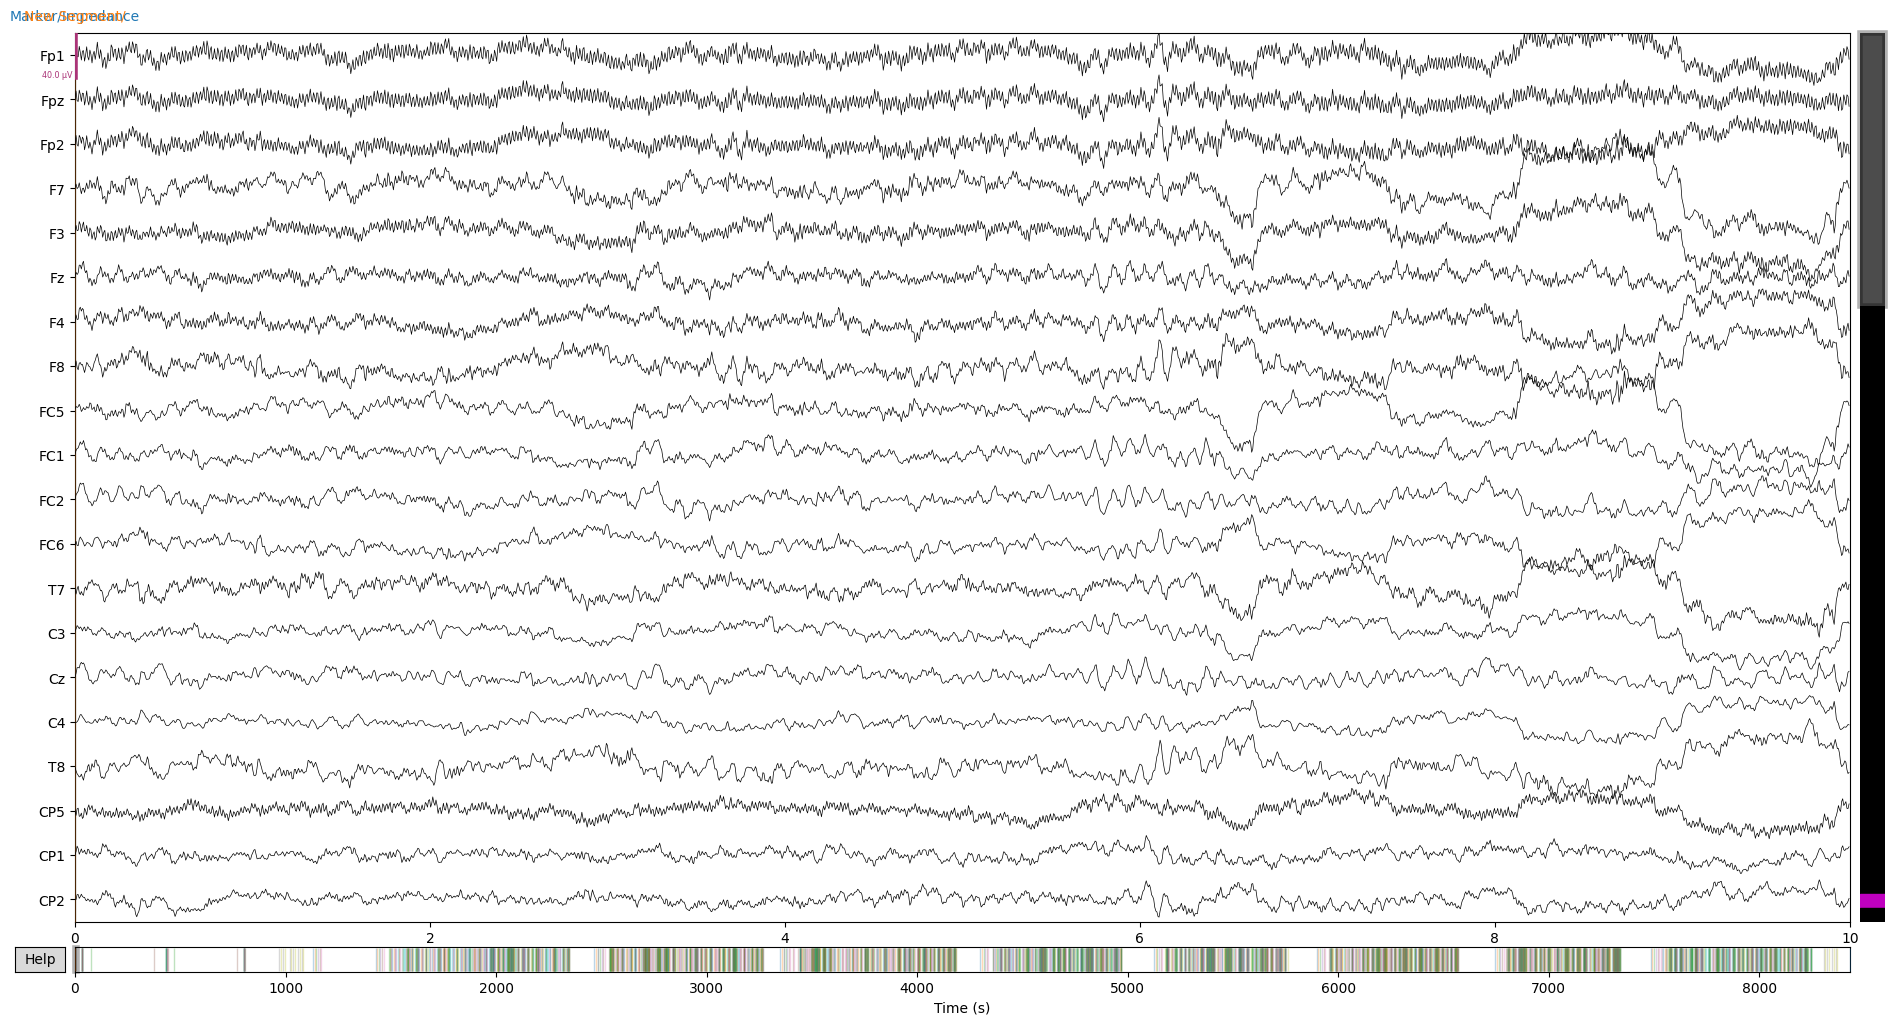

Channels marked as bad:
none


In [23]:
# Plot Resting State Cleaned
print(clean.get_data().shape)

clean.plot(duration=10, title='Cleaned Recording')




In [25]:
clean.save(f'{participant_id}_cleaned_EEG.fif', overwrite=True)


Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_cleaned_EEG.fif


C:\Users\ymijs\AppData\Local\Temp\ipykernel_10996\3023397479.py:1: RuntimeWarning: This filename (c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_cleaned_EEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean.save(f'{participant_id}_cleaned_EEG.fif', overwrite=True)


Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_cleaned_EEG.fif
Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_cleaned_EEG-1.fif
Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\P03_cleaned_EEG-1.fif
[done]
